In [ ]:
!pip install tslearn

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tslearn.metrics import cdist_dtw
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

/Users/laurenbeede/miniconda3/envs/lfads-torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = '/Users/laurenbeede/Google Drive/My Drive/STAT5243/FinalProject/Dexcom Data/'

csv_files = glob.glob(path + '*.csv')

df_list = []

for file in csv_files:
    df = pd.read_csv(file, skiprows=range(1, 11))
    df_list.append(df)

dexcom_df = pd.concat(df_list, ignore_index=True)

dexcom_df.shape

(339429, 14)

In [4]:
dexcom_df.columns

Index(['Index', 'Timestamp (YYYY-MM-DDThh:mm:ss)', 'Event Type',
       'Event Subtype', 'Patient Info', 'Device Info', 'Source Device ID',
       'Glucose Value (mg/dL)', 'Insulin Value (u)', 'Carb Value (grams)',
       'Duration (hh:mm:ss)', 'Glucose Rate of Change (mg/dL/min)',
       'Transmitter Time (Long Integer)', 'Transmitter ID'],
      dtype='object')

In [3]:
timeseries_data = dexcom_df[['Glucose Value (mg/dL)']]

In [4]:
dexcom_df.loc[dexcom_df['Glucose Value (mg/dL)'] == 'Low', 'Glucose Value (mg/dL)'] = 39
dexcom_df.loc[dexcom_df['Glucose Value (mg/dL)'] == 'High', 'Glucose Value (mg/dL)'] = 401

In [5]:
dexcom_df['Timestamp (YYYY-MM-DDThh:mm:ss)'] = pd.to_datetime(dexcom_df['Timestamp (YYYY-MM-DDThh:mm:ss)'])
dexcom_df['Glucose Value (mg/dL)'] = dexcom_df['Glucose Value (mg/dL)'].astype(int)
cols_to_drop = ['Patient Info', 'Device Info', 'Duration (hh:mm:ss)', 'Carb Value (grams)', 'Insulin Value (u)','Glucose Rate of Change (mg/dL/min)']
for col in cols_to_drop:
    dexcom_df = dexcom_df.drop(col, axis=1)
dexcom_df.head()

,Index,Timestamp (YYYY-MM-DDThh:mm:ss),Event Type,Event Subtype,Source Device ID,Glucose Value (mg/dL),Transmitter Time (Long Integer),Transmitter ID
0,11,2022-09-15 00:01:06,EGV,NaN,iOS G6,126,7024275.0,8XSKAL
1,12,2022-09-15 00:06:05,EGV,NaN,iOS G6,128,7024575.0,8XSKAL
2,13,2022-09-15 00:11:05,EGV,NaN,iOS G6,128,7024875.0,8XSKAL
3,14,2022-09-15 00:16:05,EGV,NaN,iOS G6,130,7025175.0,8XSKAL
4,15,2022-09-15 00:21:06,EGV,NaN,iOS G6,132,7025475.0,8XSKAL


In [6]:
# Maybe just start by plotting a timeframe
sept15_22 = dexcom_df[dexcom_df['Timestamp (YYYY-MM-DDThh:mm:ss)'].dt.date == pd.to_datetime('2022-09-15').date()]


In [8]:
x = sept15_22['Timestamp (YYYY-MM-DDThh:mm:ss)']
y = sept15_22['Glucose Value (mg/dL)']

([<matplotlib.axis.YTick at 0x29fa6bd60>,
 [Text(0, 67, '67'),
  Text(0, 77, '77'),
  Text(0, 87, '87'),
  Text(0, 97, '97'),
  Text(0, 107, '107'),
  Text(0, 117, '117'),
  Text(0, 127, '127'),
  Text(0, 137, '137'),
  Text(0, 147, '147'),
  Text(0, 157, '157'),
  Text(0, 167, '167'),
  Text(0, 177, '177'),
  Text(0, 187, '187'),
  Text(0, 197, '197'),
  Text(0, 207, '207'),
  Text(0, 217, '217'),
  Text(0, 227, '227')])

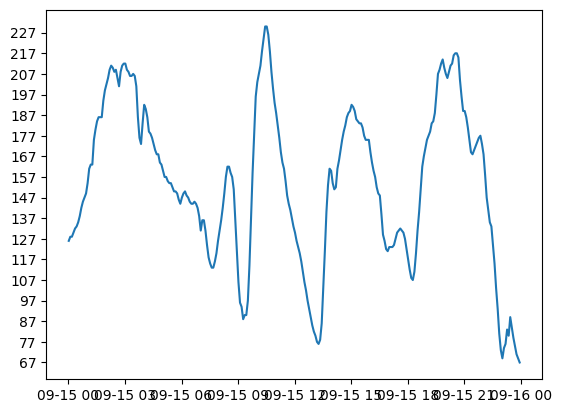

In [9]:
plt.plot(x,y)
plt.yticks(np.arange(min(y), max(y), 10))

In [20]:
# Group by week using pd.Grouper (by default, groups by end-of-week, usually Sunday)
weekly_groups = dexcom_df.groupby(pd.Grouper(key='Timestamp', freq='W'))

# Create a list of weekly time series for the glucose values.
# Each element in weekly_series is a numpy array representing one week's data.
weekly_series = [group['Glucose Value (mg/dL)'].values
                 for _, group in weekly_groups if not group.empty]

In [21]:
max_length = max(len(series) for series in weekly_series)

padded_series = []
for series in weekly_series:
    padded = np.pad(series, (0, max_length - len(series)), mode='edge')
    padded_series.append(padded)

data_array = np.array(padded_series)
data_array = data_array[..., np.newaxis]  # Add a feature dimension

print("Shape of data_array:", data_array.shape)

Shape of data_array: (172, 4008, 1)


In [23]:
normalized_data = []
scaler = MinMaxScaler()
for series in data_array:
    normalized_series = scaler.fit_transform(series)
    normalized_data.append(normalized_series)
normalized_data = np.array(normalized_data)

sample_size = 50  # adjust based on your needs
sampled_data = normalized_data[:sample_size]

In [24]:
distance_matrix = cdist_dtw(sampled_data, n_jobs=-1)

In [27]:
silhouette_scores = []
n_clusters_range = range(2, 6)  # try 2 to 5 clusters

for n_clusters in n_clusters_range:
    kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
    print('kmeans')
    clusters = kmeans.fit_predict(sampled_data)
    print('clusters')
    score = silhouette_score(distance_matrix, clusters, metric="precomputed")
    print('score')
    silhouette_scores.append(score)
    print('silhouette_scores')
    print(f'Clusters: {n_clusters}, Silhouette Score: {score}')

# Plot silhouette scores
plt.plot(list(n_clusters_range), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

kmeans


KeyboardInterrupt: 